In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
df = pd.read_csv('generations.csv')
df.head()

,size,document,splitter,score,chunk,question,relevance_rating,groundness_rating,standalone_rating,limit,collection,context,ctx_length,answer,model
0,1000,insurance_act,char,0.8,"the Special Economic Zones Act, 2005 (28 of 20...",What legal consequences (penalties) exist for ...,5,5,5,3,semantic,['26-12-2014). 40B. Limitation of expenses of ...,23940,Individuals or entities who violate the provis...,meta-llama-3.1-8b-instruct
1,1000,insurance_act,char,0.8,"the Special Economic Zones Act, 2005 (28 of 20...",What legal consequences (penalties) exist for ...,5,5,5,3,char,['domiciled outside India or any insurer as de...,5844,Individuals or entities who violate the provis...,meta-llama-3.1-8b-instruct
2,1000,insurance_act,char,0.8,"the Special Economic Zones Act, 2005 (28 of 20...",What legal consequences (penalties) exist for ...,5,5,5,3,token,"['thereof shall, in all legal proceedings (whe...",27040,Individuals or entities who violate the provis...,meta-llama-3.1-8b-instruct
3,1000,insurance_act,char,0.8,"the Special Economic Zones Act, 2005 (28 of 20...",What legal consequences (penalties) exist for ...,5,5,5,3,recursive,['(i) “policy” means a policy issued or renewe...,26431,"According to the context, individuals or entit...",meta-llama-3.1-8b-instruct
4,1000,insurance_act,char,0.8,"the Special Economic Zones Act, 2005 (28 of 20...",What legal consequences (penalties) exist for ...,5,5,5,3,semantic,['26-12-2014). 40B. Limitation of expenses of ...,23940,Individuals or entities violating provisions o...,meta-llama-3.1-8b-instruct


In [26]:
df['collection'].unique()

array(['semantic', 'char', 'token', 'recursive', 'optimized-semantic',
       'optimized-char', 'optimized-token', 'optimized-recursive'],
      dtype=object)

In [21]:
row = df.iloc[0]
reference = row['chunk']
contexts = eval(row['context'])
extracted = ''.join(contexts)

In [24]:
def lcs_length(str1, str2):
    m, n = len(str1), len(str2)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if str1[i - 1] == str2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])
    return dp[m][n]

def iou_lcs(str1, str2):
    lcs_len = lcs_length(str1, str2)
    union_len = len(str1) + len(str2) - lcs_len
    if union_len == 0:
        return 0.0
    return lcs_len / union_len


In [29]:
collections = df['collection'].unique()
limits = [3, 5]

collection_scores = {}
for collection in collections:
    collection_scores[collection] = {}

for collection in tqdm(collections):
    for limit in limits:
        collection_scores[collection][limit] = []
        subset = df[(df['collection'] == collection) & (df['limit'] == limit)]
        for _, row in subset.iterrows():
            reference = row['chunk']
            contexts = eval(row['context'])
            extracted = ''.join(contexts)
            score = iou_lcs(reference, extracted)
            collection_scores[collection][limit].append(score)

100%|██████████| 8/8 [9:52:18<00:00, 4442.25s/it]   


In [30]:
print(collection_scores.keys())

dict_keys(['semantic', 'char', 'token', 'recursive', 'optimized-semantic', 'optimized-char', 'optimized-token', 'optimized-recursive'])


In [40]:
metrics = {}

for key in collection_scores.keys():
    collection_scores[key]['any'] = collection_scores[key][3] + collection_scores[key][5]
    metrics[key] = {}

for key in collection_scores.keys():
    for limit in collection_scores[key].keys():
        metrics[key][limit] = {}
        arr = np.array(collection_scores[key][limit])
        metrics[key][limit]['mean'] = np.mean(arr)
        metrics[key][limit]['std'] = np.std(arr)        

In [46]:
data = []
for collection, limits in collection_scores.items():
    for limit, values in limits.items():
        data.append({'collection': collection, 'limit': limit, 'values': values})

df = pd.DataFrame(data)

In [48]:
df.to_csv('iou-scores.csv')

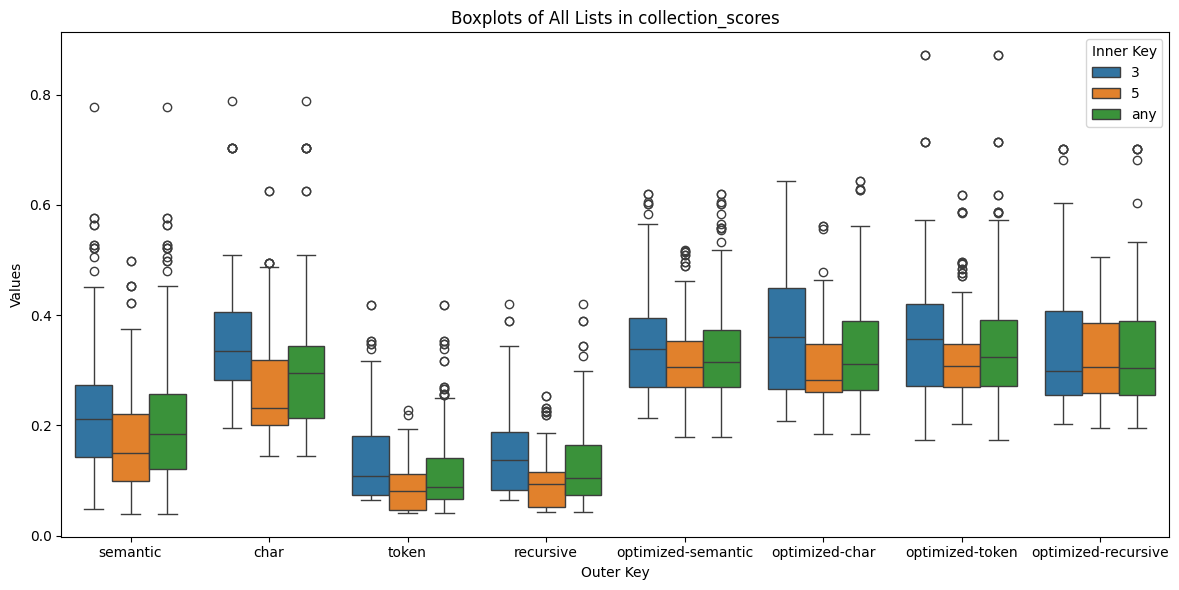

In [43]:
data = []
for outer_key, inner_dict in collection_scores.items():
    for inner_key, values in inner_dict.items():
        for v in values:
            data.append({'outer': outer_key, 'inner': str(inner_key), 'value': v})

df = pd.DataFrame(data)

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x='outer', y='value', hue='inner', data=df)
plt.title('Boxplots of All Lists in collection_scores')
plt.xlabel('Outer Key')
plt.ylabel('Values')
plt.legend(title='Inner Key')
plt.tight_layout()
plt.show()

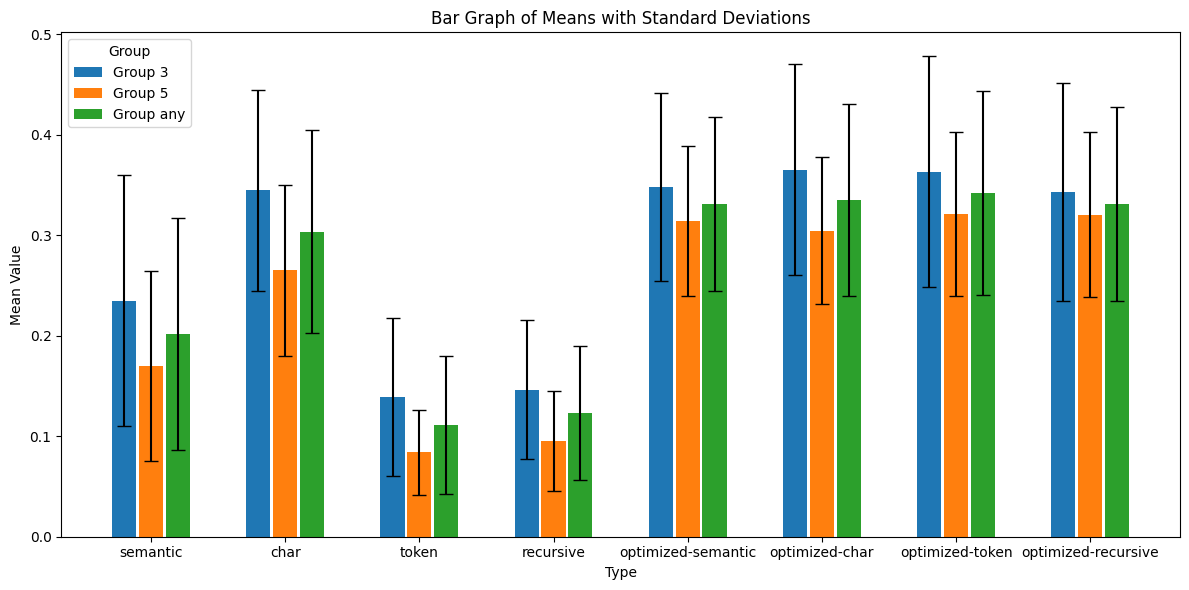

In [42]:
data = []
for outer_key, inner_dict in metrics.items():
    for inner_key, stats in inner_dict.items():
        data.append({
            'Type': outer_key,
            'Group': str(inner_key),
            'Mean': float(stats['mean']),
            'Std': float(stats['std'])
        })

df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(12, 6))
# Create a grouped bar plot
for idx, group in enumerate(df['Group'].unique()):
    subset = df[df['Group'] == group]
    plt.bar(
        [x + idx*0.2 for x in range(len(subset))],
        subset['Mean'],
        yerr=subset['Std'],
        width=0.18,
        label=f'Group {group}',
        capsize=5
    )

plt.xticks([x + 0.2 for x in range(len(df['Type'].unique()))], df['Type'].unique())
plt.xlabel('Type')
plt.ylabel('Mean Value')
plt.title('Bar Graph of Means with Standard Deviations')
plt.legend(title='Group')
plt.tight_layout()
plt.show()